In [1]:
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from edward.models import Categorical, Mixture, Normal, MultivariateNormalDiag
import time

In [2]:
def generate_data():
    """Generating some Slightly fuzzy sine wave data."""
    NSAMPLE = 50000
    print("Generating",str(NSAMPLE), "toy data samples.")
    t_data = np.float32(np.array(range(NSAMPLE))/10.0)
    t_interval = t_data[1] - t_data[0]
    t_r_data = np.random.normal(0,t_interval/20.0,size=NSAMPLE)
    t_data = t_data + t_r_data
    
    r_data = np.random.normal(size=NSAMPLE)
    x_data = np.sin(t_data) * 7.0 + r_data * 1.0
    df = pd.DataFrame({'t':t_data, 'x':x_data})
    
    #plt.show(df[500:600].plot.scatter('t','x'))
    df.t = df.t.diff()
    df.t = df.t.fillna(1e-4)
    print(df.describe())
    
    #plt.figure(figsize=(8, 8))
    #plt.plot(t_data,x_data,'ro', alpha=0.3)
    #plt.show()
    return np.array(df)



In [3]:
## Preparing sequences for MDN:
class SequenceDataLoader(object):
    """Manages data from a sequence and generates epochs"""
    def __init__(self, num_steps, batch_size, corpus):
        """load corpus and generate examples"""
        self.num_steps = num_steps
        self.batch_size = batch_size
        self.corpus = corpus
        self.examples = self.setup_training_examples()
        print("Done initialising loader.")

    def setup_training_examples(self):
        xs = []
        for i in range(len(self.corpus) - self.num_steps - 1):
            example = self.corpus[i : i + self.num_steps]
            xs.append(example)
        print("Total training examples:", str(len(xs)))
        return xs
    
    def next_epoch(self):
        """Return an epoch of batches of shuffled examples."""
        np.random.shuffle(self.examples)
        batches = []
        for i in range(len(self.examples) / self.batch_size):
            batch = self.examples[i * self.batch_size : (i + 1) * self.batch_size]
            batches.append(batch)
        return(np.array(batches))


NET_MODE_TRAIN = 'train'
NET_MODE_RUN = 'run'
MODEL_DIR = "/Users/charles/src/mdn-experiments/"
LOG_PATH = "/tmp/tensorflow/"

class TinyJamNet2D(object):
    def __init__(self, mode = NET_MODE_TRAIN, n_hidden_units = 24, n_mixtures = 24, batch_size = 100, sequence_length = 100):
        """Initialise the TinyJamNet model. Use mode='run' for evaluation graph and mode='train' for training graph."""
        # hyperparameters
        self.n_hidden_units = n_hidden_units
        self.n_rnn_layers = 3
        self.batch_size = batch_size
        self.sequence_length = sequence_length
        self.st_dev = 0.5 
        self.n_mixtures = n_mixtures # number of mixtures
        self.n_input_units = 2 # Number of dimensions of the input (and sampled output) data
        self.mdn_splits = 5 # (pi, sigma_1, sigma_2, mu_1, mu_2) # forget about (rho) for now.
        self.n_output_units = n_mixtures * self.mdn_splits # KMIX * self.mdn_splits
        self.lr = 1e-4 # could be 1e-3
        self.lr_decay_rate = 0.9999,  # Learning rate decay per minibatch.
        self.lr_minimum = 0.00001,  # Minimum learning rate.
        self.grad_clip=1.0
        self.state = None

        tf.reset_default_graph()
        self.graph = tf.get_default_graph()
        
        with self.graph.as_default():
            with tf.name_scope('input'):
                self.x = tf.placeholder(dtype=tf.float32, shape=[self.batch_size,self.sequence_length,self.n_input_units], name="x") # input
                self.y = tf.placeholder(dtype=tf.float32, shape=[self.batch_size,self.sequence_length,self.n_input_units], name="y") # target
            
            self.rnn_outputs, self.init_state, self.final_state = self.recurrent_network(self.x)
            self.rnn_outputs = tf.reshape(self.rnn_outputs,[-1,self.n_hidden_units], name = "reshape_rnn_outputs")
            
            output_params = self.fully_connected_layer(self.rnn_outputs,self.n_hidden_units,self.n_output_units)
            
            logits, scales_1, scales_2, locs_1, locs_2 = self.split_tensor_to_mixture_parameters(output_params)
            cat = Categorical(logits=logits)
            locs = tf.stack([locs_1, locs_2], axis=1)
            scales = tf.stack([scales_1, scales_2],axis=1)
            coll = [MultivariateNormalDiag(loc=loc, scale_diag=scale) for loc, scale 
                    in zip(tf.unstack(locs,axis=-1),tf.unstack(scales,axis=-1))]
            
            self.mixture = Mixture(cat=cat, 
                                   components=coll, 
                                   value=tf.zeros([self.batch_size * self.sequence_length,self.n_input_units], dtype=tf.float32)
                                  )
            # Saver
            self.saver = tf.train.Saver(name = "saver")
            if (mode is NET_MODE_TRAIN):
                print("Loading Training Operations")
                self.global_step = tf.Variable(0, name='global_step', trainable=False)
                y_reshaped = tf.reshape(self.y,[-1,self.n_input_units], name = "reshape_labels")
                self.cost = self.loss_function(self.mixture, y_reshaped)
                optimizer = tf.train.AdamOptimizer(self.lr)
                gvs = optimizer.compute_gradients(self.cost)
                g = self.grad_clip
                capped_gvs = [(tf.clip_by_value(grad, -g, g), var) for grad, var in gvs]
                self.train_op = optimizer.apply_gradients(gvs, global_step=self.global_step, name='train_step')
                #self.train_op = optimizer.minimize(self.cost, name="train_step")
                self.training_state = None
                tf.summary.scalar("cost_summary", self.cost)
            
            if (mode is NET_MODE_RUN):
                print("Loading Running Operations")
                self.sample = self.mixture.sample()
            # Summaries
            self.summaries = tf.summary.merge_all()

        self.writer = tf.summary.FileWriter(LOG_PATH, graph=self.graph)
        train_vars_count = np.sum([np.prod(v.get_shape().as_list()) for v in tf.trainable_variables()])

        print("done initialising:", self.model_name(), "vars:", str(train_vars_count))
                    
    def loss_function(self,mixture,Y):
        loss = self.mixture.log_prob(Y)
        loss = tf.negative(loss)
        loss = tf.reduce_sum(loss)
        return loss
        
    def fully_connected_layer(self, X, in_dim, out_dim):
        with tf.name_scope('rnn_to_mdn'):
            W = tf.Variable(tf.random_normal([in_dim,out_dim], stddev=self.st_dev, dtype=tf.float32))
            b = tf.Variable(tf.random_normal([1,out_dim], stddev=self.st_dev, dtype=tf.float32))
            output = tf.matmul(X,W) + b
        return output
    
    def recurrent_network(self, X):
        with tf.name_scope('recurrent_network'):
            cells_list = [tf.contrib.rnn.LSTMCell(self.n_hidden_units,state_is_tuple=True) for _ in range(self.n_rnn_layers)]
            cell = tf.contrib.rnn.MultiRNNCell(cells_list, state_is_tuple=True)
            init_state = cell.zero_state(self.batch_size,tf.float32)
            rnn_outputs, final_state = tf.nn.dynamic_rnn(
                cell, 
                X, 
                initial_state=init_state, 
                time_major = False, 
                dtype=tf.float32, 
                scope='RNN'
            )
        return rnn_outputs, init_state, final_state
        
    def split_tensor_to_mixture_parameters(self, output):
        # Split up the output nodes into three groups for Pis, Sigmas and Mus.
        logits, scales_1, scales_2, locs_1, locs_2 = tf.split(value=output, num_or_size_splits=self.mdn_splits, axis=1)
        # Transform the sigmas to e^sigma
        scales_1 = tf.exp(scales_1)
        scales_2 = tf.exp(scales_2)
        # Transform the correlations to tanh(corr)
        #corr = tf.tanh(corr)
        return logits, scales_1, scales_2, locs_1, locs_2
    
    def model_name(self):
        """Returns the name of the present model for saving to disk"""
        return "tiny-perf-mdn-" + str(self.n_rnn_layers) + "layers-" + str(self.n_hidden_units) + "units"
    
    def train_batch(self, batch, sess):
        """Train the network on one batch"""
        ## batch is an array of shape (batch_size, sequence_length + 1, n_input_units)
        batch_x = batch[:,:self.sequence_length,:]
        batch_y = batch[:,1:,:]
        feed = {self.x: batch_x, self.y: batch_y}
        if self.training_state is not None:
            feed[self.init_state] = self.training_state
        training_loss_current, self.training_state, _ = sess.run([self.cost,self.final_state,self.train_op],feed_dict=feed)
        return training_loss_current

    def train_epoch(self, batches, sess):
        """Train the network on one epoch of training data."""
        total_training_loss = 0
        steps = 0
        total_steps = len(batches)
        for b in batches:
            training_loss = self.train_batch(b, sess)
            steps += 1
            total_training_loss += training_loss
            if (steps % 10 == 0):
                print("Trained batch:", str(steps), "of", str(total_steps), "loss was:", str(training_loss))
        return total_training_loss/steps
    
    def train(self, data_manager, num_epochs, saving=True):
        """Train the network for the a number of epochs."""
        # often 30
        self.num_epochs = num_epochs
        print("Going to train: " + self.model_name())
        start_time = time.time()
        training_losses = []
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            for i in range(num_epochs):
                batches = data_manager.next_epoch()
                print("Starting Epoch", str(i), "of", str(self.num_epochs))
                epoch_average_loss = self.train_epoch(batches,sess)
                training_losses.append(epoch_average_loss)
                print("Trained Epoch", str(i), "of", str(self.num_epochs))
                if saving:
                    self.saver.save(sess, LOG_PATH + "/" + self.model_name() + ".ckpt", i)
            if saving:
                self.saver.save(sess,self.model_name())
        print("It took ", time.time() - start_time, " to train the network.")
        return training_losses
    
    def prepare_model_for_running(self,sess):
        """Load trained model and reset RNN state."""
        sess.run(tf.global_variables_initializer())
        self.saver.restore(sess, MODEL_DIR + self.model_name())
        self.state = None
        
    def generate_touch(self,prev_touch,sess):
        """Generate prediction for a single touch."""
        input_touch = prev_touch.reshape([1,1,self.n_input_units]) ## Give input correct shape for one-at-a-time evaluation.
        if self.state is not None:
            feed = {self.x: input_touch, self.init_state: self.state}
        else:
            feed = {self.x: input_touch}
        prediction, self.state = sess.run([self.sample,self.final_state],feed_dict=feed)
        return prediction
    
    def generate_performance(self,first_touch,number,sess):
        self.prepare_model_for_running(sess)
        previous_touch = first_touch
        performance = [previous_touch.reshape((self.n_input_units,))]
        for i in range(number):
            previous_touch = self.generate_touch(previous_touch,sess)
            performance.append(previous_touch.reshape((self.n_input_units,)))
        return np.array(performance)


In [ ]:
## Training Test
## Train on sequences of length 121 with batch size 100.
def test_training():
    x_t_log = generate_data()
    loader = SequenceDataLoader(num_steps = 121,batch_size = 100, corpus = x_t_log)
    net = TinyJamNet2D(mode = NET_MODE_TRAIN, n_hidden_units = 128, n_mixtures = 10, batch_size = 100, sequence_length = 120)
    losses = net.train(loader, 30, saving=True)
    print(losses)
    ## Plot the losses.


Generating 50000 toy data samples.
                  t             x
count  50000.000000  50000.000000
mean       0.099998      0.001426
std        0.007067      5.051751
min        0.000100    -10.553367
25%        0.095244     -4.802637
50%        0.099962      0.006726
75%        0.104714      4.858680
max        0.130734     10.920672
Loading Running Operations
done initialising: tiny-perf-mdn-3layers-128units vars: 336690
INFO:tensorflow:Restoring parameters from /Users/charles/src/mdn-experiments/tiny-perf-mdn-3layers-128units


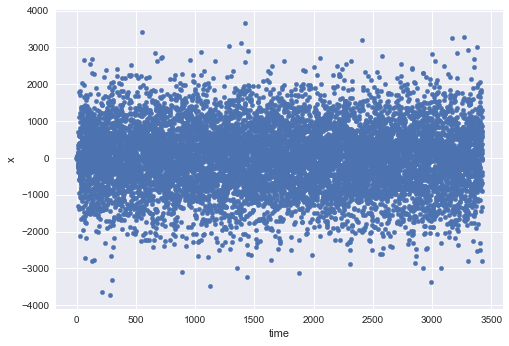

In [8]:
## Evaluation Test:
## Predict 10000 Datapoints.


test_x_t = generate_data()


net = TinyJamNet2D(mode = NET_MODE_RUN, n_hidden_units = 128, n_mixtures = 10, batch_size = 1, sequence_length = 1)
first_touch = test_x_t[1000].reshape((1,1,2))

with tf.Session() as sess:
    perf = net.generate_performance(first_touch,10000,sess)
perf_df = pd.DataFrame({'t':perf.T[0], 'x':perf.T[1]})
perf_df['time'] = perf_df.t.cumsum()
plt.show(perf_df.plot('time','x',kind='scatter'))

Window: 1000 to 1100


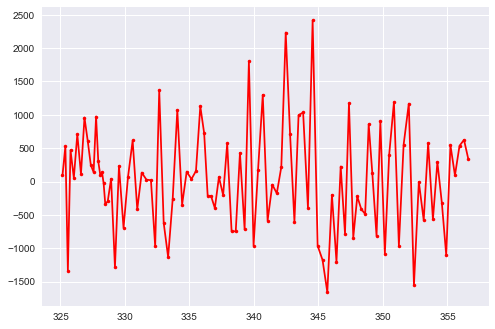

Window: 2000 to 2100


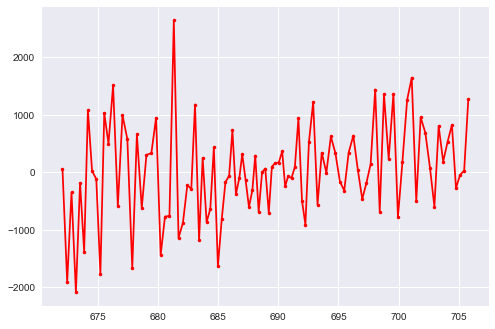

Window: 3000 to 3100


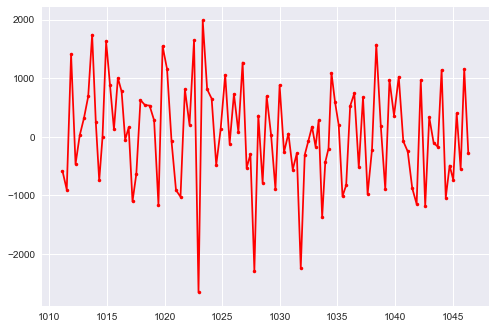

Window: 4000 to 4100


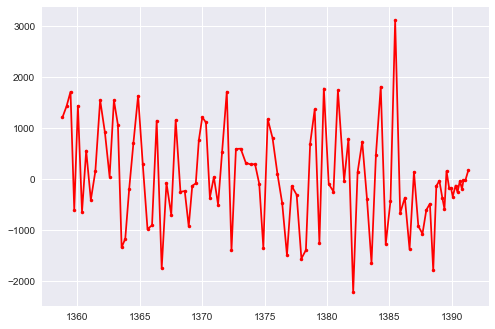

Window: 5000 to 5100


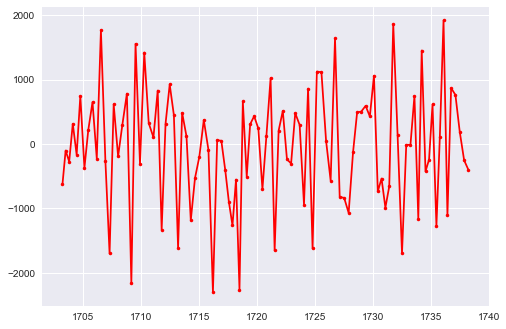

Window: 6000 to 6100


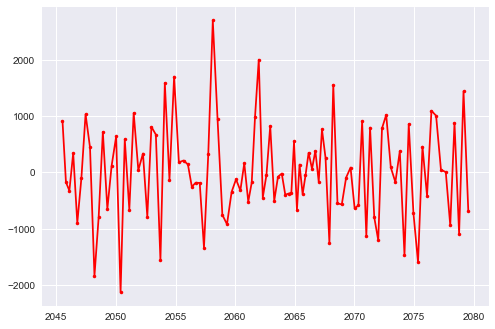

                  t             x          time
count  10001.000000  10001.000000  10001.000000
mean       0.342327     -2.268841   1702.779482
std        0.050777    875.038553    993.793772
min       -0.791859  -3724.876953     -0.370355
25%        0.320790   -577.442322    841.273952
50%        0.353500     18.278986   1703.253355
75%        0.375569    559.740601   2565.062582
max        0.790001   3650.528809   3423.610247


In [9]:
## Investigate Output
window = 100
for n in [1000,2000,3000,4000,5000,6000]:
    print("Window:", str(n),'to',str(n+window))
    plt.plot(perf_df[n:n+window].time, perf_df[n:n+window].x, '.r-')
    plt.show()

print(perf_df.describe())

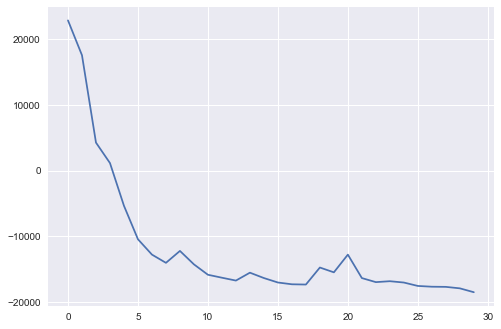

In [10]:
## Training Discussion
## Losses over 30 epochs:
losses = [22901.954809472263, 17586.698399647172, 4264.8230513147564, 1143.5517320249933, -5373.3117116905123, -10477.778792231917, -12818.44131788384, -14072.937982704745, -12256.409315974837, -14305.405835929167, -15891.284362915529, -16341.383685621391, -16777.71922749592, -15573.864470455062, -16393.092865357918, -17072.193927075488, -17344.130974551281, -17383.776837574907, -14787.659655720354, -15522.463964071618, -12819.659858948735, -16396.494901971168, -17015.207802155888, -16874.642990173586, -17077.171243047138, -17597.177961234585, -17714.277263717959, -17737.939705599743, -17962.198043639401, -18552.904021971677]
plt.plot(losses)
plt.show()

